In [1]:
# Import
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.api import OLS
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
# Install the 'pmdarima' package
#import sys
#!{sys.executable} -m pip install pmdarima

In [3]:
# Read the csv into 'df'
df = pd.read_csv('/home/stephen/Desktop/ForecastingCaseStudy/SalesProduct4.csv')

In [4]:
# Format the 'Month' column to YYYY-MM-DD & set the 'Month' column data type to 'datetime64[ns]'
month_list = list()
for x in range(len(df)):
    month_list.append(df.iloc[x]['Month'])

df2 = pd.DataFrame({'Month': month_list})
df2['Month'] = pd.to_datetime(df2['Month']).dt.strftime('%Y-%m-%d')
df2['Sales Product 4'] = df['Sales Product 4']

df2['Month'] = df2['Month'].astype('datetime64[ns]')

In [5]:
# Set the 'Month' column as the index of 'df2'
df2.set_index('Month', inplace=True)

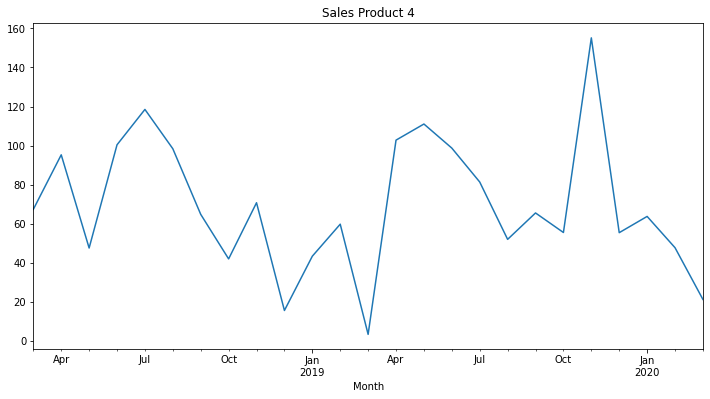

In [6]:
# Plot the time series to see if it is additive or multiplicative
plot = df2.plot(figsize=(12,6), title='Sales Product 4', legend=False)

# Save the plot to a PNG
fig = plot.get_figure()
fig.savefig('SalesProduct4_PlotA.png')

The time series is multiplicative because the peaks & troughs do not stay roughly the same across the level.

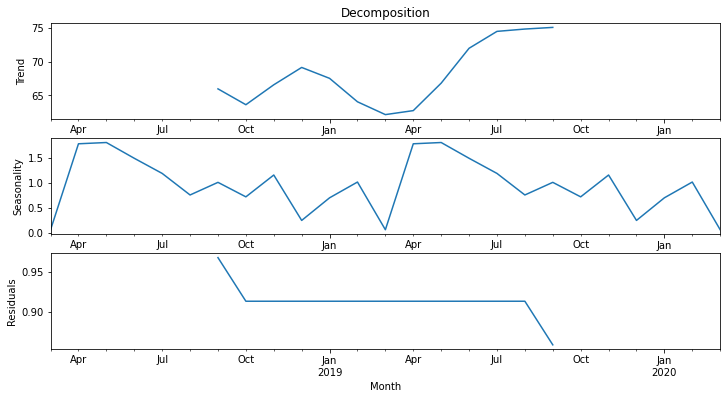

In [7]:
# Decompose the time series into trend, seasonal & residual components
decompose_result = seasonal_decompose(df2, model="multiplicative")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residuals = decompose_result.resid

# Plot the decomposition
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,6))
trend.plot(ax=ax1, title='Decomposition')
ax1.set_ylabel('Trend')
seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonality')
residuals.plot(ax=ax3)
ax3.set_ylabel('Residuals')

# Save the decomposition plots to a PNG
fig.savefig('SalesProduct4_PlotB_Decomposition.png')

# ARIMA

In [8]:
# Augmented Dickey-Fuller test to test for stationarity
adf_test = ADFTest(alpha = 0.05) # 0.05 is the significance level
adf_test.should_diff(df2)

(0.4624840190319015, True)

The results are the p-value & whether the time series is stationary or not. True = stationary. False = not stationary.

In [9]:
# Create the training & testing subsets
train = df2[0:19]
test = df2[19:]

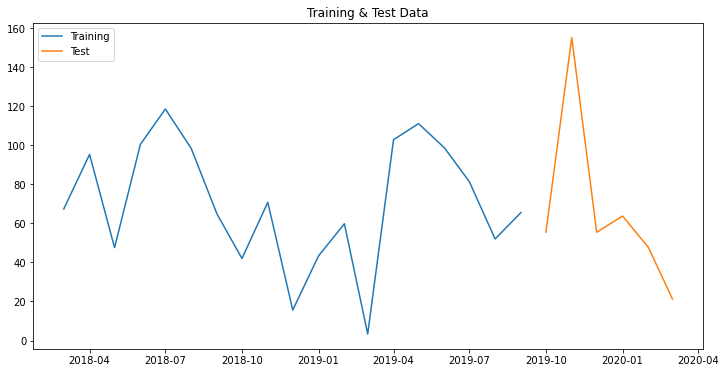

In [10]:
# Plot the 'train' & 'test' subsets
plt.figure(figsize=(12,6))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.title('Training & Test Data')
plt.legend(loc="upper left")
plt.show()

In [11]:
# Run 'auto_arima'.
# All the paramaters you will need, even for other time series, are included here.
# Read more about the parameters here: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
arima_model = auto_arima(train, start_p=0, d=0, start_q=0,
                        max_p=5, max_d=0, max_q=5,
                        start_P=0, D=0, start_Q=0,
                        max_P=5, max_D=5, max_Q=5,
                        max_order=None, m=12, seasonal=True,
                        stationary=True, method='lbfgs', 
                        error_action='warn', trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=188.473, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=191.234, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=191.173, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=220.977, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=190.317, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=190.317, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=192.317, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=189.394, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=189.430, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=191.393, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.420 seconds


In [12]:
# View the model summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   19
Model:                        SARIMAX   Log Likelihood                 -92.237
Date:                Sun, 11 Apr 2021   AIC                            188.473
Time:                        11:28:47   BIC                            190.362
Sample:                             0   HQIC                           188.793
                                 - 19                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     70.4458      7.578      9.296      0.000      55.593      85.299
sigma2       964.1412    396.581      2.431      0.015     186.857    1741.425
===================================================================================
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.26   Prob(JB):                         0.67
Heteroskedasticity (H):               0.77   Skew:                            -0.40
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Forecast/make predictions
pred = pd.DataFrame(arima_model.predict(n_periods=6), index=test.index)
pred.columns = ['predicted_sales']
pred

,predicted_sales
Month,
2019-10-01,70.445784
2019-11-01,70.445784
2019-12-01,70.445784
2020-01-01,70.445784
2020-02-01,70.445784
2020-03-01,70.445784


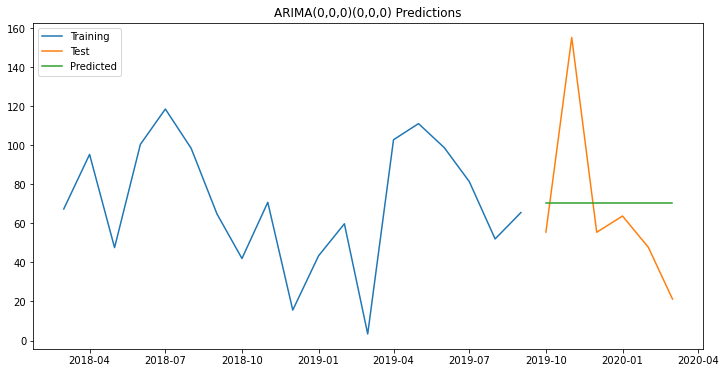

In [14]:
# Plot the predicted forecast against the training & test subsets
plt.figure(figsize=(12,6))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(pred, label='Predicted')
plt.title('ARIMA(0,0,0)(0,0,0) Predictions')
plt.legend(loc="upper left")
plt.show()

In [15]:
# Evaluate forecast using mean absolute error
MAE = mean_absolute_error(test, pred)
MAE_rounded = round(MAE, 3)

# Evaluate forecast using root mean squared error
RMSE = mean_squared_error(test, pred, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Evaluate forecast using mean absolute scaled error (w/non-seasonal naive forecast)
#def mase(y_test, y_pred, y_naive):
#    e_t = y_test - y_pred
#    scale = mean_absolute_error(y_test, y_naive)
#    return np.mean(np.abs(e_t / scale))
#MASE = mase(test, pred, df2[18:24])
#MASE_rounded = round(MASE, 3)

# Create a dataframe containing all the error calculations
model = ['ARIMA(0,0,0)(0,0,0)']
df_errors = pd.DataFrame({'Model':model})
df_errors['MAE'] = MAE_rounded
df_errors['RMSE'] = RMSE_rounded
df_errors['MAPE'] = MAPE_string
#df_errors['MASE'] = MASE_rounded
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%


# Exponential Smoothing

### Simple Exponential Smoothing
Used because there are only a few data points.

In [16]:
# Create the training & testing subsets
train = df2[0:19]
test = df2[19:]

In [36]:
# Build the simple exponential smooting models & use them to make predictions for the next 6 months
model = SimpleExpSmoothing(np.asarray(train))

fit1 = model.fit() # Auto-optimized smoothing level
pred1 = fit1.forecast(6)
fit2 = model.fit(smoothing_level=0.2)
pred2 = fit2.forecast(6)
fit3 = model.fit(smoothing_level=0.5)
pred3 = fit3.forecast(6)
fit4 = model.fit(smoothing_level=0.8)
pred4 = fit4.forecast(6)

/home/stephen/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


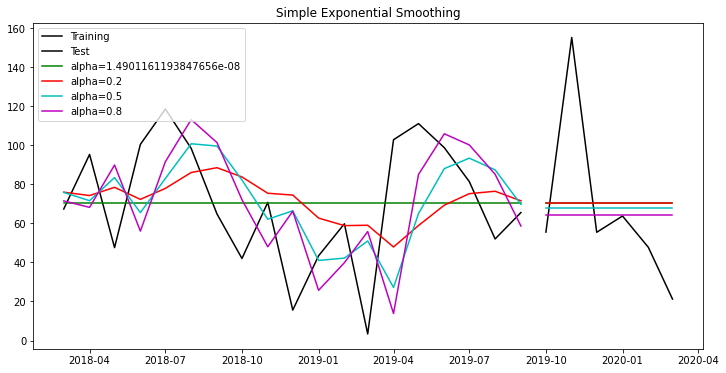

In [38]:
# Plot all the predictions against the actual values
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train.index, train, color='k', label='Training')
ax.plot(test.index, test, color='k', label='Test')
for p, f, c in zip((pred1, pred2, pred3, pred4), (fit1, fit2, fit3, fit4), ('g','r','c', 'm')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha=" + str(f.params['smoothing_level']), color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend(loc="upper left")
plt.show()

In [39]:
# Evaluate 'pred1' forecast using mean absolute error
MAE = mean_absolute_error(test, pred1)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred1' forecast using root mean squared error
RMSE = mean_squared_error(test, pred1, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred1' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred1)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred1' to 'df_errors'
row_to_add = ['SES; alpha = 0.0', MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%


In [40]:
# Evaluate 'pred2' forecast using mean absolute error
MAE = mean_absolute_error(test, pred2)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred2' forecast using root mean squared error
RMSE = mean_squared_error(test, pred2, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred2' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred2)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred2' to 'df_errors'
row_to_add = ['SES; alpha = 0.2', MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%


In [41]:
# Evaluate 'pred3' forecast using mean absolute error
MAE = mean_absolute_error(test, pred3)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred3' forecast using root mean squared error
RMSE = mean_squared_error(test, pred3, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred3' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred3)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred3' to 'df_errors'
row_to_add = ['SES; alpha = 0.5', MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%


In [42]:
# Evaluate 'pred4' forecast using mean absolute error
MAE = mean_absolute_error(test, pred4)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred4' forecast using root mean squared error
RMSE = mean_squared_error(test, pred4, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred4' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred4)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred4' to 'df_errors'
row_to_add = ['SES; alpha = 0.8', MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%


### Holt's Linear Smoothing
You're supposed to use this model when there is a linear trend in the data & no seasonality. You used it here just to try it out.

In [43]:
# Create the training & testing subsets
train = df2[0:19]
test = df2[19:]

In [110]:
# Build Holt's linear smoothing models & use them to make predictions for the next 6 months
model = Holt(np.asarray(train))

fit1 = model.fit(optimized=True) # Auto-optimized
pred1 = fit1.forecast(6)
fit2 = model.fit(smoothing_level=0.3, smoothing_trend=0.05)
pred2 = fit2.forecast(6)
fit3 = model.fit(smoothing_level=0.3, smoothing_trend=0.2)
pred3 = fit3.forecast(6)
fit4 = model.fit(smoothing_level=0.04, smoothing_trend=0.3)
pred4 = fit4.forecast(6)

/home/stephen/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


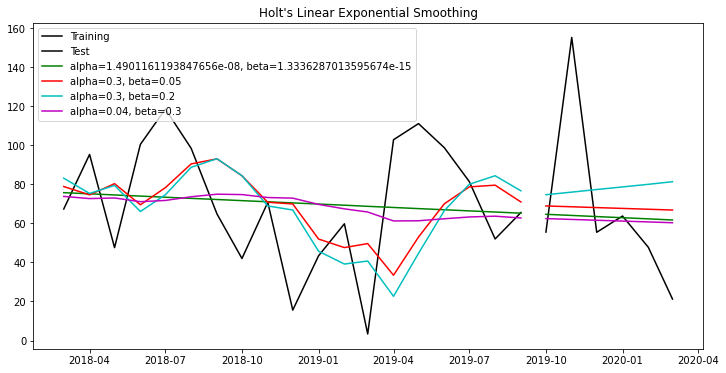

In [112]:
# Plot all the predictions against the actual values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train, color='k', label='Training')
ax.plot(test.index, test, color='k', label='Test')
for p, f, c in zip((pred1, pred2, pred3, pred4),(fit1, fit2, fit3, fit4),('g','r','c', 'm')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha=" + str(f.params['smoothing_level']) + ", beta=" + str(f.params['smoothing_trend']), color=c)
plt.title("Holt's Linear Exponential Smoothing")
plt.legend(loc="upper left")
plt.show()

In [113]:
# Evaluate 'pred1' forecast using mean absolute error
MAE = mean_absolute_error(test, pred1)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred1' forecast using root mean squared error
RMSE = mean_squared_error(test, pred1, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred1' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred1)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred1' to 'df_errors'
row_to_add = ["Holt's Linear; alpha = 0.0; beta = 0.0", MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%


In [114]:
# Evaluate 'pred2' forecast using mean absolute error
MAE = mean_absolute_error(test, pred2)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred2' forecast using root mean squared error
RMSE = mean_squared_error(test, pred2, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred2' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred2)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred2' to 'df_errors'
row_to_add = ["Holt's Linear; alpha = 0.3; beta = 0.05", MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%


In [115]:
# Evaluate 'pred3' forecast using mean absolute error
MAE = mean_absolute_error(test, pred3)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred3' forecast using root mean squared error
RMSE = mean_squared_error(test, pred3, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred3' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred3)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred3' to 'df_errors'
row_to_add = ["Holt's Linear; alpha = 0.3; beta = 0.2", MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%


In [116]:
# Evaluate 'pred4' forecast using mean absolute error
MAE = mean_absolute_error(test, pred4)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred4' forecast using root mean squared error
RMSE = mean_squared_error(test, pred4, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred4' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred4)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred4' to 'df_errors'
row_to_add = ["Holt's Linear; alpha = 0.04; beta = 0.3", MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%


### Holt-Winters Seasonal

In [117]:
# Create the training & testing subsets
train = df2[0:19]
test = df2[19:]

In [118]:
# Build Holt-Winters seasonal models & use them to make predictions for the next 6 months
model1 = ExponentialSmoothing(train, trend="mul", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12)
model3 = ExponentialSmoothing(train, trend="mul", seasonal="add", seasonal_periods=12, damped_trend=True)
model4 = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12, damped_trend=True)

fit1 = model1.fit() # Auto-optimized
pred1 = fit1.forecast(6)
fit2 = model1.fit(smoothing_level=0.04, smoothing_trend=0.3)
pred2 = fit2.forecast(6)

fit3 = model2.fit() # Auto-optimized
pred3 = fit3.forecast(6)
fit4 = model2.fit(smoothing_level=0.04, smoothing_trend=0.3)
pred4 = fit4.forecast(6)

fit5 = model3.fit() # Auto-optimized
pred5 = fit5.forecast(6)
fit6 = model3.fit(smoothing_level=0.04, smoothing_trend=0.3)
pred6 = fit6.forecast(6)

fit7 = model4.fit() # Auto-optimized
pred7 = fit7.forecast(6)
fit8 = model4.fit(smoothing_level=0.04, smoothing_trend=0.3)
pred8 = fit8.forecast(6)

/home/stephen/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stephen/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/stephen/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stephen/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stephen/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency inform

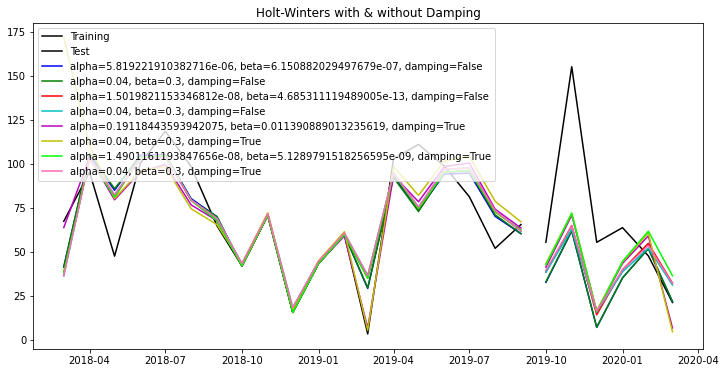

In [119]:
# Plot the predicted values against the actual values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train, color='k', label='Training')
ax.plot(test.index, test, color='k', label='Test')
for p, f, c in zip((pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8), 
                   (fit1, fit2, fit3, fit4, fit5, fit6, fit7, fit8),
                   ('b', 'g', 'r', 'c', 'm', 'y', 'lime', 'hotpink')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha=" + str(f.params['smoothing_level']) + ", beta=" + str(f.params['smoothing_trend']) + ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
plt.title("Holt-Winters with & without Damping");
plt.legend(loc="upper left")
plt.show()

In [120]:
# Evaluate 'pred1' forecast using mean absolute error
MAE = mean_absolute_error(test, pred1)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred1' forecast using root mean squared error
RMSE = mean_squared_error(test, pred1, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred1' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred1)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred1' to 'df_errors'
row_to_add = ["Holt-Winters; mul/add; alpha = 0.0; beta = 0.0; damping = False", 
              MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


In [121]:
# Evaluate 'pred2' forecast using mean absolute error
MAE = mean_absolute_error(test, pred2)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred2' forecast using root mean squared error
RMSE = mean_squared_error(test, pred2, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred2' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred2)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred2' to 'df_errors'
row_to_add = ["Holt-Winters; mul/add; alpha = 0.04; beta = 0.3; damping = False", 
              MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


In [122]:
# Evaluate 'pred3' forecast using mean absolute error
MAE = mean_absolute_error(test, pred3)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred3' forecast using root mean squared error
RMSE = mean_squared_error(test, pred3, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred3' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred3)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred3' to 'df_errors'
row_to_add = ["Holt-Winters; mul/mul; alpha = 0.0; beta = 0.0; damping = False", 
              MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


In [123]:
# Evaluate 'pred4' forecast using mean absolute error
MAE = mean_absolute_error(test, pred4)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred4' forecast using root mean squared error
RMSE = mean_squared_error(test, pred4, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred4' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred4)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred4' to 'df_errors'
row_to_add = ["Holt-Winters; mul/mul; alpha = 0.04; beta = 0.3; damping = False", 
              MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


In [124]:
# Evaluate 'pred5' forecast using mean absolute error
MAE = mean_absolute_error(test, pred5)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred5' forecast using root mean squared error
RMSE = mean_squared_error(test, pred5, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred5' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred5)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred5' to 'df_errors'
row_to_add = ["Holt-Winters; mul/add; alpha = 0.19; beta = 0.01; damping = True", 
              MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


In [125]:
# Evaluate 'pred6' forecast using mean absolute error
MAE = mean_absolute_error(test, pred6)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred6' forecast using root mean squared error
RMSE = mean_squared_error(test, pred6, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred6' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred6)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred6' to 'df_errors'
row_to_add = ["Holt-Winters; mul/add; alpha = 0.04; beta = 0.3; damping = True", 
              MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


In [126]:
# Evaluate 'pred7' forecast using mean absolute error
MAE = mean_absolute_error(test, pred7)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred7' forecast using root mean squared error
RMSE = mean_squared_error(test, pred7, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred7' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred7)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred7' to 'df_errors'
row_to_add = ["Holt-Winters; mul/mul; alpha = 0.0; beta = 0.0; damping = True", 
              MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


In [127]:
# Evaluate 'pred8' forecast using mean absolute error
MAE = mean_absolute_error(test, pred8)
MAE_rounded = round(MAE, 3)

# Evaluate 'pred8' forecast using root mean squared error
RMSE = mean_squared_error(test, pred8, squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'pred8' forecast using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, pred8)
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'pred8' to 'df_errors'
row_to_add = ["Holt-Winters; mul/mul; alpha = 0.04; beta = 0.3; damping = True", 
              MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


# Facebook Prophet

In [128]:
# Create a new training subset dataframe whose columns have been renamed to 
# 'ds' ('Month') & 'y' ('Sales Product 4') to comply with Prophet requirements
df_prophet = df[:19].rename(columns={'Month': 'ds', 'Sales Product 4': 'y'})

# Create the test subset
test = df2[19:]

In [129]:
# Initiate a new Prophet object
m = Prophet()

# Fit the model to df_prod
m.fit(df_prophet)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.


In [130]:
# Set the number of periods to be forecasted.
# In this case we want to predict the next 6 periods.
# Set 'freq' equal to 'MS' for Month Start.
future = m.make_future_dataframe(periods=6, freq='MS')
future

,ds
0,2018-03-01
1,2018-04-01
2,2018-05-01
3,2018-06-01
4,2018-07-01
5,2018-08-01
6,2018-09-01
7,2018-10-01
8,2018-11-01
9,2018-12-01


In [131]:
# Use 'predict' to assign each row in 'future' a predicted value, which it names yhat.
# 'predict' also adds 11 uncertainty intervals.
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-03-01,76.053540,34.489005,119.422437
1,2018-04-01,75.439728,33.478301,115.805727
2,2018-05-01,74.845717,36.621429,113.388275
3,2018-06-01,74.231905,32.428430,112.658816
4,2018-07-01,73.637893,32.290336,111.938554
5,2018-08-01,73.024081,33.215936,114.242032
6,2018-09-01,72.410269,32.557841,109.603120
7,2018-10-01,71.816257,31.867013,110.810988
8,2018-11-01,71.202445,26.759842,111.334017
9,2018-12-01,70.608433,32.869956,110.982424


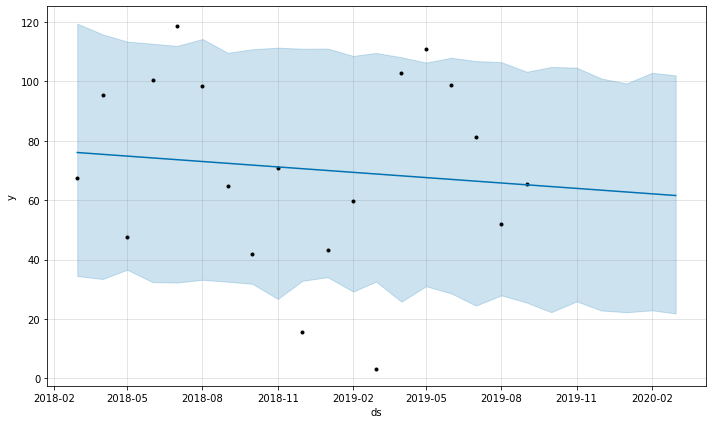

In [132]:
# Plot the forecast
fig1 = m.plot(forecast)

In [133]:
# Evaluate 'forecast' predictions using mean absolute error
MAE = mean_absolute_error(test, forecast['yhat'][19:])
MAE_rounded = round(MAE, 3)

# Evaluate 'forecast' predictions using root mean squared error
RMSE = mean_squared_error(test, forecast['yhat'][19:], squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'forecast' predictions using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, forecast['yhat'][19:])
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'forecast' to 'df_errors'
row_to_add = ["Prophet Default", MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


In [134]:
#help(Prophet)

In [193]:
# Build a new, tuned model
m2 = Prophet(changepoint_range=0.9, 
            seasonality_mode='multiplicative', 
            changepoint_prior_scale=0.01, 
            interval_width=0.95)
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=6.5)
m2.fit(df_prophet)
future2 = m2.make_future_dataframe(periods=6, freq='MS')
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.


,ds,yhat,yhat_lower,yhat_upper
0,2018-03-01,84.992098,28.059140,138.745463
1,2018-04-01,71.989325,10.263471,129.469021
2,2018-05-01,83.158497,29.372227,139.495108
3,2018-06-01,70.419027,12.696089,128.729718
4,2018-07-01,81.324895,22.214834,139.430029
5,2018-08-01,68.848728,7.639366,127.167772
6,2018-09-01,60.057105,2.242699,121.653181
7,2018-10-01,67.278429,5.060337,125.261368
8,2018-11-01,58.671262,1.642281,115.037826
9,2018-12-01,65.708131,8.246639,118.595686


In [194]:
# Evaluate 'forecast2' predictions using mean absolute error
MAE = mean_absolute_error(test, forecast2['yhat'][19:])
MAE_rounded = round(MAE, 3)

# Evaluate 'forecast2' predictions using root mean squared error
RMSE = mean_squared_error(test, forecast2['yhat'][19:], squared=False)
RMSE_rounded = round(RMSE, 3)

# Evaluate 'forecast2' predictions using mean absolute percentage error
def mape(actuals, preds): 
    a, p = np.array(actuals), np.array(preds)
    return np.mean(np.abs((a - p) / a)) * 100
MAPE = mape(test, forecast2['yhat'][19:])
MAPE_rounded = round(MAPE, 3)
MAPE_string = str(MAPE_rounded) + '%'

# Add the error measures of 'forecast2' to 'df_errors'
row_to_add = ["Prophet Tuned", MAE_rounded, RMSE_rounded, MAPE_string]
df_errors.loc[len(df_errors.index)] = row_to_add
df_errors

,Model,MAE,RMSE,MAPE
0,"ARIMA(0,0,0)(0,0,0)",32.223,42.048,66.431%
1,SES; alpha = 0.0,32.220,42.048,66.425%
2,SES; alpha = 0.2,32.144,42.037,66.207%
3,SES; alpha = 0.5,30.321,41.874,61.043%
4,SES; alpha = 0.8,28.014,41.924,54.504%
5,Holt's Linear; alpha = 0.0; beta = 0.0,27.363,41.436,53.071%
6,Holt's Linear; alpha = 0.3; beta = 0.05,30.277,41.481,61.51%
7,Holt's Linear; alpha = 0.3; beta = 0.2,37.906,44.695,80.649%
8,Holt's Linear; alpha = 0.04; beta = 0.3,26.815,41.766,50.502%
9,Holt-Winters; mul/add; alpha = 0.0; beta = 0.0...,32.935,45.454,55.055%


# Export 'df_errors' to Excel

In [195]:
# Set the 'Model' column as the index of 'df_errors'
df_errors.set_index('Model', inplace=True)

In [196]:
# Write 'df_errors' to an Excel spreadsheet
df_errors.to_excel('/home/stephen/Desktop/ForecastingCaseStudy/SalesProduct4_Accuracy.xlsx', index = True)